In [1]:
%env PROJ_LIB=/home/pavel/develop/anaconda2/envs/ds/share/proj/

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

### Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [3]:
grouped = pd.read_csv('../grouped_regions_trips_count.csv', parse_dates=['time'])
grouped.head()

time  region  trips_count
0 2016-05-01       1            0
1 2016-05-01       2            0
2 2016-05-01       3            0
3 2016-05-01       4            0
4 2016-05-01       5            0

In [4]:
region_trips_count = grouped.groupby(['region'])['trips_count'].sum()
print 'Число ячеек без поездок: %s' % sum(region_trips_count == 0)

Число ячеек без поездок: 1283


### Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

In [5]:
lat_min, lat_max = 40.49612, 40.91553
long_min, long_max = -74.25559, -73.70001
empire_lat, empire_long = 40.748817, -73.985428

# EPSG код взят отсюда: http://spatialreference.org/ref/epsg/?search=new+york+&srtext=Search
NYC_EPSG_CODE = 2261

In [6]:
def get_lat_space(num):
    return np.linspace(lat_min, lat_max, num + 1)


def get_long_space(num):
    return np.linspace(long_min, long_max, num + 1)

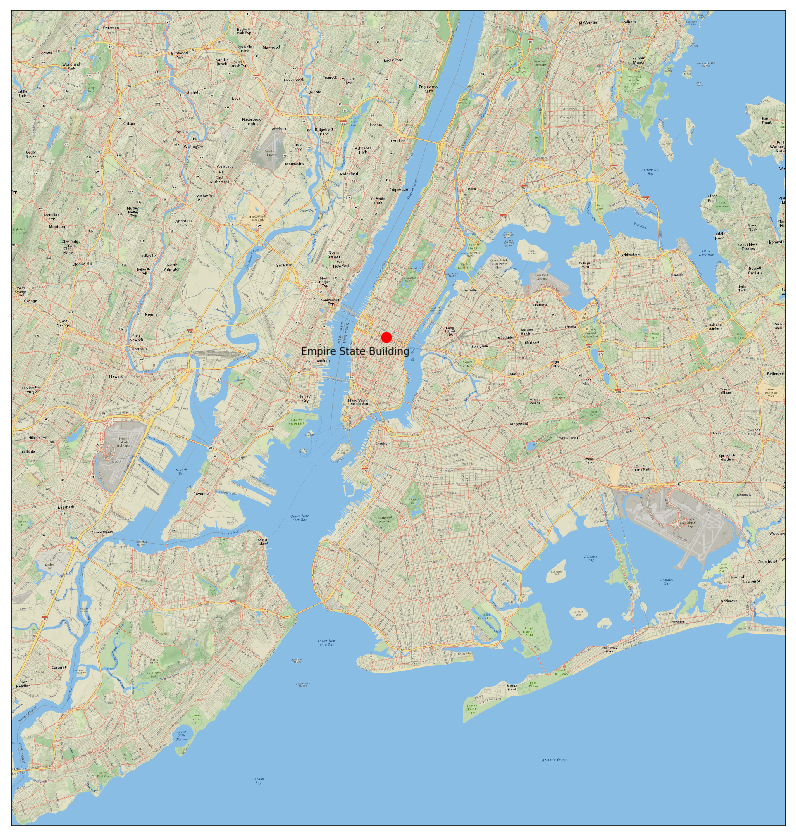

CPU times: user 2.11 s, sys: 132 ms, total: 2.25 s
Wall time: 28.3 s


In [7]:
%%time

fig = plt.figure(figsize=(15,15))
m = Basemap(llcrnrlat=lat_min, llcrnrlon=long_min, 
            urcrnrlat=lat_max, urcrnrlon=long_max,
            epsg=NYC_EPSG_CODE)
m.arcgisimage(xpixels=2000, service='NatGeo_World_Map')

empire_x, empire_y = m(empire_long, empire_lat)
m.plot(empire_x, empire_y, 'ro', markersize=10)
plt.text(empire_x - 5000, empire_y - 1000, 'Empire State Building', color='black')

plt.show()

### Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [7]:
lat_space = get_lat_space(50)
long_space = get_long_space(50)

In [8]:
# scaled_data = np.log(region_trips_count + 1)
scaled_data = region_trips_count + 1
data = scaled_data.values.reshape((50, 50)).T

In [9]:
from matplotlib.colors import LogNorm


def plot_static_map_with_colormesh(lat_space, long_space, mesh_data, cmap='hot', xpixels=2000):
    fig = plt.figure(figsize=(17,15))
    m = Basemap(llcrnrlat=lat_min, llcrnrlon=long_min, 
                urcrnrlat=lat_max, urcrnrlon=long_max,
                epsg=NYC_EPSG_CODE)

    m.arcgisimage(xpixels=xpixels, service='World_Topo_Map')
    m.pcolormesh(long_space, lat_space, mesh_data, 
                 norm=LogNorm(vmin=1, vmax=np.max(mesh_data)),
                 latlon=True, alpha=0.5, cmap=cmap)

    empire_x, empire_y = m(empire_long, empire_lat)
    m.plot(empire_x, empire_y, 'ro', markersize=10)
    plt.text(empire_x - 5000, empire_y - 1000, 'Empire State Building', color='black')

    plt.colorbar(orientation='vertical', shrink=0.85, label='Trips Count')

    plt.show()  

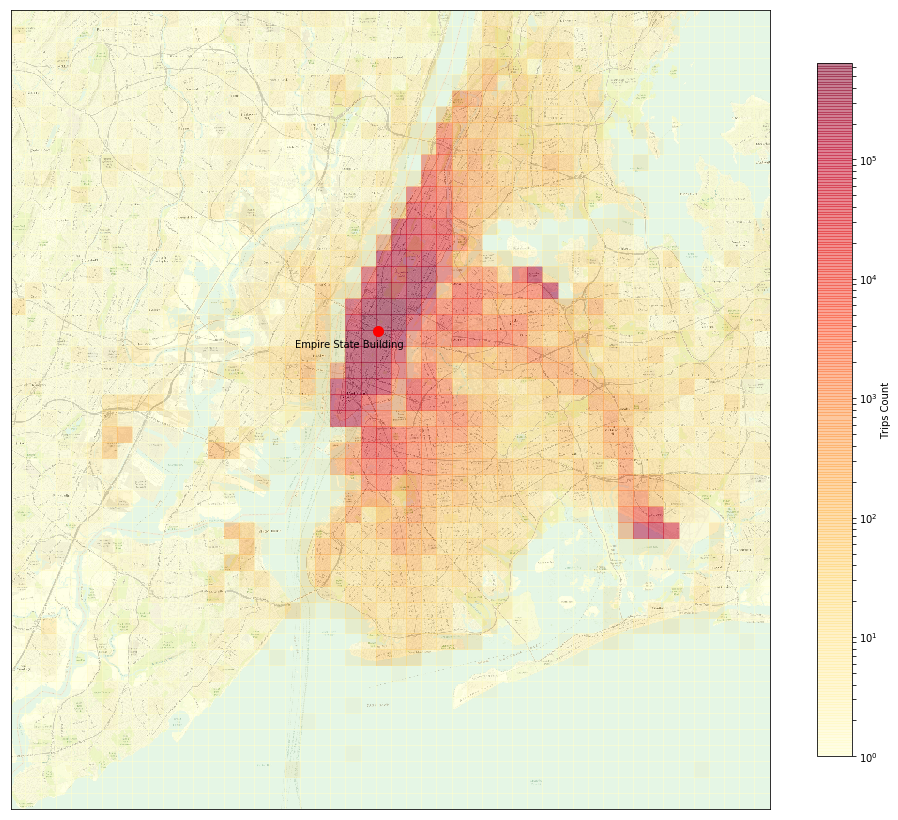

CPU times: user 3.01 s, sys: 150 ms, total: 3.16 s
Wall time: 22.2 s


In [76]:
%%time

plot_static_map_with_colormesh(lat_space, long_space, data, xpixels=2000, cmap='YlOrRd')

**_Для большей наглядности выведем ту же карту, но с разбиением ячеек не 50x50, а 200x200. Данные для этого были посчитаны в ноутбуке первой недели и сохранены в файл._**

In [86]:
%%time

grouped_hires = pd.read_csv('../grouped_regions_trips_count_hires.csv')
data_hires = grouped_hires.groupby(['region'])['trips_count'].sum()

CPU times: user 10 s, sys: 1.13 s, total: 11.2 s
Wall time: 11.2 s


In [11]:
data_hires.shape

(40000,)

In [12]:
scaled_data_hires = data_hires + 1
data_hires = scaled_data_hires.values.reshape((200, 200)).T

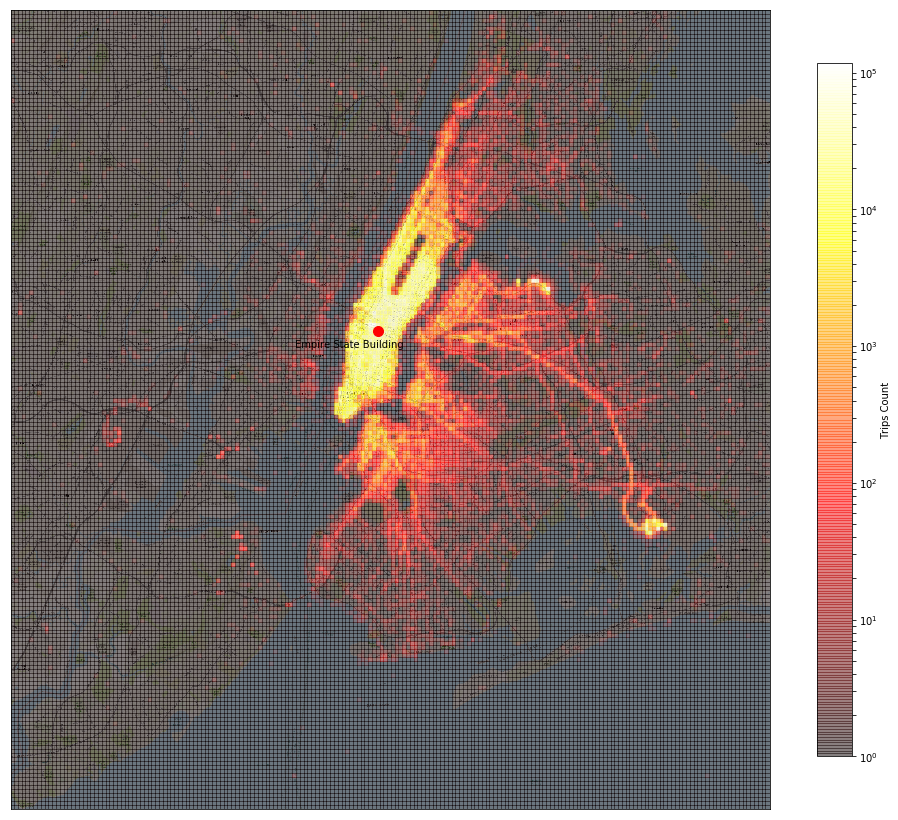

CPU times: user 2.96 s, sys: 222 ms, total: 3.18 s
Wall time: 23.4 s


In [13]:
%%time

plot_static_map_with_colormesh(get_lat_space(200), 
                               get_long_space(200), 
                               data_hires, cmap='hot')

### Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [16]:
import folium
from IPython.core.display import display, HTML

In [17]:
statue_lat, statue_long = 40.689247, -74.044502
map_center = [np.mean([lat_min, lat_max]), np.mean([long_min, long_max])]

In [18]:
def show_map(folium_map):
    display(HTML(folium_map._repr_html_().replace('padding-bottom:60%', 'padding-bottom:85%')))

In [21]:
m = folium.Map(location=map_center,
               width=800, height=800,
               zoom_start=11)
folium.Marker([statue_lat, statue_long], popup='Statue of Liberty').add_to(m)
show_map(m)

### Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [127]:
mean_hour_trips_count = grouped.groupby(['region'])['trips_count'].mean()

In [149]:
from matplotlib.colors import Normalize, LogNorm, rgb2hex
from matplotlib.cm import ScalarMappable


def plot_folium_map_with_colormesh(lat_space, long_space, density, cmap='hot', fill_opacity=0.5,
                                   cell_filter_func=lambda x: True):
    m = folium.Map(location=map_center,
                   width=800, height=800,
                   zoom_start=11)
    density = density + 1
    norm = LogNorm(vmin=np.min(density), 
                   vmax=np.max(density))
    mapper = ScalarMappable(norm=norm, cmap=cmap)

    for i, lat_low in enumerate(lat_space[:-1]):
        for j, lon_low in enumerate(long_space[:-1]):
            if not cell_filter_func(density[i][j]):
                continue
            
            color = rgb2hex(mapper.to_rgba(density[i][j])[:3])
            folium.Rectangle(bounds=((lat_low, lon_low), 
                                     (lat_space[i+1], long_space[j+1])),
                             color=color,
                             opacity=0.3,
                             weight=1,
                             fill_opacity=fill_opacity,
                             fill_color=color).add_to(m)
    show_map(m)

In [150]:
%%time

plot_folium_map_with_colormesh(get_lat_space(50), 
                               get_long_space(50), 
                               mean_hour_trips_count.values.reshape((50, 50)).T, 
                               cmap='YlOrRd')

CPU times: user 3.01 s, sys: 15.5 ms, total: 3.02 s
Wall time: 3.04 s


### Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [131]:
len(mean_hour_trips_count[mean_hour_trips_count >= 5])

102

In [151]:
%%time

plot_folium_map_with_colormesh(get_lat_space(50), 
                               get_long_space(50), 
                               mean_hour_trips_count.values.reshape((50, 50)).T,
                               cell_filter_func=lambda x: x >= 5,
                               fill_opacity=0.8,
                               cmap='YlOrRd')

CPU times: user 224 ms, sys: 6.75 ms, total: 231 ms
Wall time: 232 ms


На карте мы видим, что все заполненные ячейки (т.е. со средним количеством поездок не менее 5) расположены на суше, т.е. поездки в них не являются невозможными.